<a href="https://colab.research.google.com/github/adventurousAyan/AyanRepo/blob/master/Train_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
import seaborn as sns

import statistics
from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb


In [2]:
# Copy from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]):
            # skip datetime type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
## reading train and test data
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_data.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_data.csv")

In [4]:
## reading weather data
weather_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_weather.csv")
weather_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_weather.csv")

In [5]:
## reading farm metadata
farm = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/farm_data.csv")
#df_train = df_train.merge(farm, on="farm_id")
#df_test = df_test.merge(farm, on="farm_id")

In [22]:

def time_features(df):
    
    # Sort by timestamp
    df.sort_values("date")
    df.reset_index(drop=True)
    
    # Add more features
    df["date"] = pd.to_datetime(df["date"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.weekday

    df['month'] = df['date'].dt.month

   
    return df
#weather_df  = time_features(weather_train)
df_train  = time_features(df_train)

In [6]:
farm.head()

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369


In [7]:
farm = farm.drop(['operations_commencing_year','num_processing_plants'],axis=1)

In [8]:

farm['farm_area'] = np.log1p(farm['farm_area'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of yield')

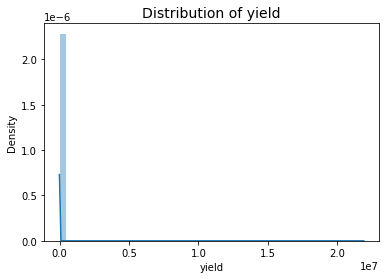

In [9]:
# set the histogram, mean and median
sns.distplot(df_train['yield'],
             kde=True)

# set title, legends and labels
plt.title("Distribution of yield", size=14)

**Yield values are highly skewed.
This picture shows that high percentage of them are gathered around zero. And unfortunately due this high skewness it is impossible to visualize raw yield values and draw a histogram**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of yield')

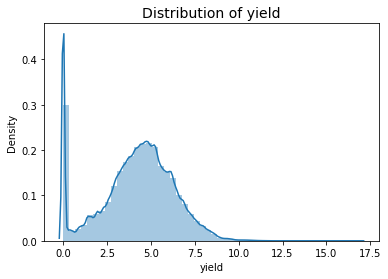

In [10]:

# set the histogram, mean and median
sns.distplot(np.log1p(df_train['yield']),
             kde=True)

# set title, legends and labels
plt.title("Distribution of yield", size=14)

**Median value is smaller than the mean value proving this skewness. This skewness is caused by the significanlty high number of 0 measurements in the yield values**

In [11]:
positive_train = df_train[df_train['yield'] != 0]
positive_train['log_yield'] = np.log(positive_train['yield'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of Logarithm(Yield) w/o 0 Measurements')

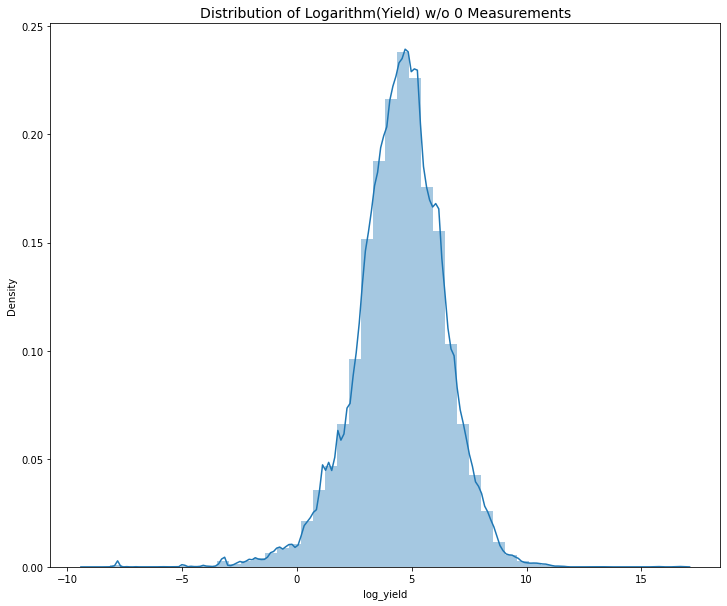

In [15]:
# set the plot size
plt.figure(figsize=(12,10))

# set the histogram, mean and median
sns.distplot(positive_train['log_yield'], 
             kde=True)


# set title, legends and labels
plt.title("Distribution of Logarithm(Yield) w/o 0 Measurements", size=14)

Text(0.5, 1.0, 'Density of Logartihm(Yield + 1) Among Different Ingredient_Types')

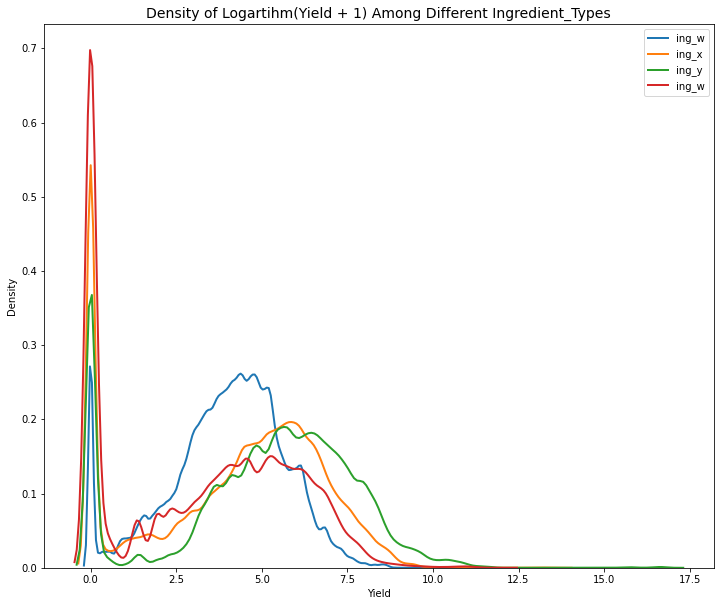

In [18]:
# distribution of the yield  without zeros
plt.figure(figsize=(12,10))

#list of different ingredients
ingredients = sorted(df_train['ingredient_type'].unique().tolist())

# plot meter_reading distribution for each ingredient
for ingredient_type in ingredients:
    subset = df_train[df_train['ingredient_type'] == ingredient_type]
    sns.kdeplot(np.log1p(subset["yield"]), 
                label=ingredient_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Yield")
plt.legend(['ing_w', 'ing_x', 'ing_y', 'ing_z'])
plt.title("Density of Logartihm(Yield + 1) Among Different Ingredient_Types", size=14)


Again for the visualization purposes, we are looking at the distribution of the np.log1p(yield) values.

1. One thing that is obvious is; significant number of observations 0 are coming from 'ing_x', 'ing_y' and 'ing_z'

2. This picture shows that yield values shows different distribution in each 
ingredient category, especially 'ing_w' is different than others. Thus, ingredient_type is a signifcant variable to determine the yield values.



**Monthly and Hourly analysis of each ingredient type**

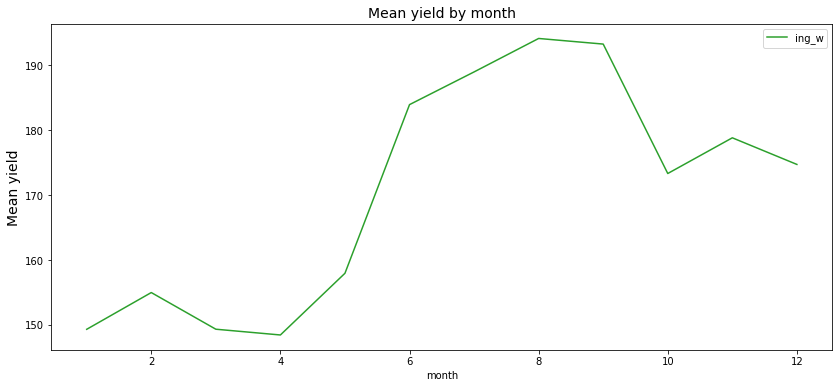

In [25]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = df_train[df_train['ingredient_type'] == 'ing_w']
subset.groupby('month')['yield'].mean().plot(color='#2ca02c');
axes.set_title('Mean yield by month', fontsize=14);
axes.set_ylabel('Mean yield', fontsize=14);

plt.legend(['ing_w'])

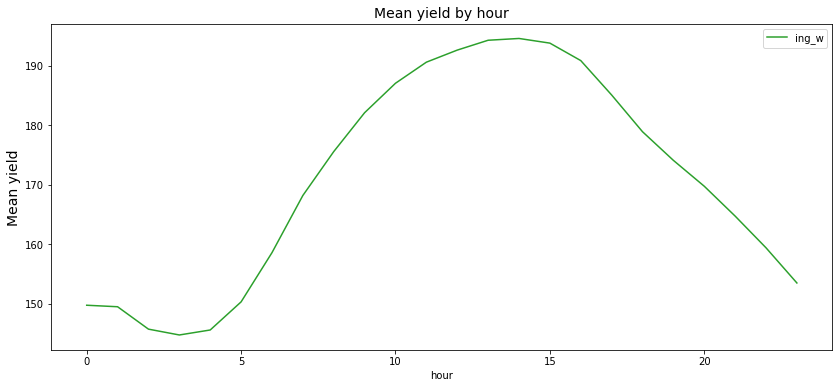

In [27]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = df_train[df_train['ingredient_type'] == 'ing_w']
subset.groupby('hour')['yield'].mean().plot(color='#2ca02c');
axes.set_title('Mean yield by hour', fontsize=14);
axes.set_ylabel('Mean yield', fontsize=14);

plt.legend(['ing_w'])

1. 'ing_w' observations spread between 0 and 220 tonnes.

2. Yields for 'ing_w' are low till may

3. For the second half consumption increases and ranges between 160 and 220 tonnes. In general 'ing_w' yields shows an increasing trend in 2016.

4. Daily peak yields comes at afternoon it averages nearly 190 tonnes

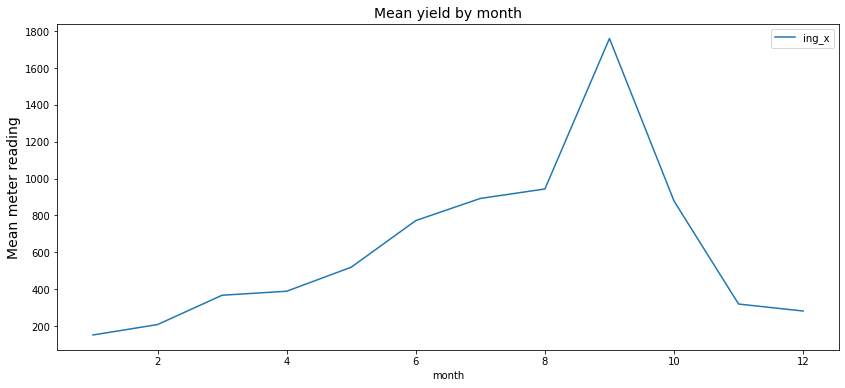

In [28]:

fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = df_train[df_train['ingredient_type'] == 'ing_x']
subset.groupby('month')['yield'].mean().plot(color='#1f77b4');
axes.set_title('Mean yield by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['ing_x'])

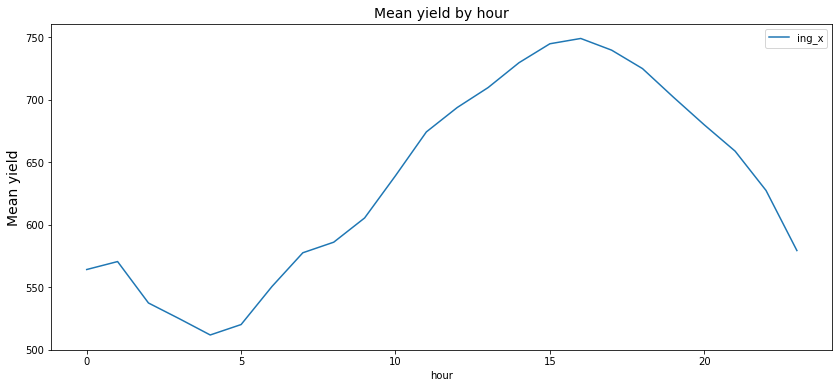

In [29]:

fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = df_train[df_train['ingredient_type'] == 'ing_x']
subset.groupby('hour')['yield'].mean().plot(color='#1f77b4');
axes.set_title('Mean yield by hour', fontsize=14);
axes.set_ylabel('Mean yield', fontsize=14);
plt.legend(['ing_x'])

1. 'ing_x' yields ranges between 130 - 1800 tonnes.

2. It shows a steady increase up to 1000 tonne until September 2016. Between September and October, there are spikes in the consumption causing the range going up to 1800 tonne.

3. Starting from November it shows downward trend.

4. 'ing_x' is peak at afternoon as expected